# Library

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError
from requests.exceptions import MissingSchema

import time
import datetime
from datetime import datetime, timedelta

import re
import gc

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

## Folders & Files

In [51]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

# files
page_s = '/page_parsing_status.csv'

artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
artinvest_lt = '/artinvest_long_text.csv'

theartnewspaper_d = '/theartnewspaper_data_new.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'

## Sites' list for parsing

In [3]:
urls_news = ['https://www.theartnewspaper.ru/', 'https://artinvestment.ru/'] # 'https://artguide.com/', 'http://artuzel.com/', 
# https://artguide.com/ - <div class="chromeframe">
#    Ваш браузер <em>устарел!</em> <a href="http://browsehappy.com/">Установите другой браузер</a> или
#    <a href="http://www.google.com/chromeframe/?redirect=true">Google Chrome Frame</a>, чтобы просматривать этот сайт.
urls_datasets = ['https://artchive.ru/', 'https://artinvestment.ru/']
urls_archives = ['https://russianartarchive.net/ru'] # есть API - https://api.raan.garagemca.org/documentation/#/
urls_fairs = ['https://www.cosmoscow.com/ru/']

In [4]:
# topping up dict (manually yet)
#                             site,       s_file,        d_file,        lt_file
df_dict = {'https://www.theartnewspaper.ru/': ['-', theartnewspaper_d, theartnewspaper_lt], 
           'https://artinvestment.ru/': [artinvest_s, artinvest_d, artinvest_lt]
           }

# Unused code

In [ ]:
# drop part of df
#artinvest_news_articles_data = artinvest_news_articles_data.drop(artinvest_news_articles_data[artinvest_news_articles_data['page_url']=='20220209_Hirst.html'].index)

In [ ]:
# delete all data from df
#artinvest_news_articles_data = artinvest_news_articles_data[0:0]
#theartnewspaper_data = theartnewspaper_data[0:0]

In [ ]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Functions
correct:
- fix labels in some graphics
- unify stat graf

## Openings and savings
1. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
2. __open_file_csv(file, folder)__ -> df - Open file.csv
3. __save_df_file(df, file, folder)__ -> - Save df to csv file
4. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
5. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp

In [52]:
# 1. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 2. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 3. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)

# 4. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 5. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

## Data mining
6. __get_page(url)__ -> bs_page - Collect request status
7. __get_parsing_lists(site)__ -> links, titles - Get links & titles lists
8. Parsing pages_counter_stat:
- 8.1 __get_artinvest_pages_counter_stat(page_url, page, parsing_links, parsing_titles)__ -> df_counter_new - Parsing artinvest pages_counter_stat
9. Parsing current news_articles_data:
- 9.1 __get_artinvest_pages_curr_data(page_url, page, parsing_links, parsing_titles)__ -> df_data_new, long_text_url_list_new, print(message) - Parsing artinvest current news_articles_data
- 9.2 __get_tanp_pages_curr_data(page_url, page, parsing_links, parsing_titles)__ -> df_data_new, long_text_url_list_new, print(message) - Parsing tanp current news_articles_data
10. Parsing long texts:
- 10.1 __get_artinvest_long_text(text_page)__ -> long_text_list_new, sourses_list_new, parsing_speed_list_new - Parsing artinvest long texts
- 10.2 __get_tanp_long_text(text_page)__ -> long_text_list_new, sourses_list_new, parsing_speed_list_new - Parsing tanp long texts
11. Functions aggrigators:
- 11.1 __parsing_agg_sd(site, s_file, d_file, lt_file)__ -> print(message) - Getting pages_counter_stat, pages_curr_data csv files and json long_text_url_list_temp
- 11.2 __parsing_agg_lt(lt_file)__ -> print(message) - Getting long texts files
12. __long_text_problems_fix(lt_file, df)__ -> print(message) - Fixing long text problems
13. __get_news_articles_archive(s_file, d_file, lt_file, p_url)__ -> - Parsing news_articles_data ARCHIVE
14. __date_transfomation(cell)__ -> cell - Date transfomation
15. __get_stat_graphics()__ - Stat graphics
16. __get_articles_graphic(df)__ - Articles counting

### get_page

In [6]:
# 6. Collect request status - saving every get result

def get_page(url):
  start_time = time.time()

  response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'}) # timeout=0.001
# Edge/97.0.1072.55
# Chrome/97.0.4692.71
  try:
    response.raise_for_status()

  except requests.exceptions.HTTPError: # for correction
    sys.exit(print('HTTPError'))

#except (HTTPError, MissingSchema): 
# 503 Server Error: Service Temporarily Unavailable for url: https://artinvestment.ru/news/artnews/ 
# Invalid URL

  else:
    get_page_stat_new = pd.DataFrame({'page_url': [url],
                                      'status_code': [response.status_code],
                                      'encoding': [response.encoding],
                                      'raise_for_status': [response.raise_for_status()],
                                      'parsing_date': [datetime.now().date()],
                                      'parsing_time': [datetime.now().time()],
                                      'parsing_sec_speed': [time.time() - start_time]})

    bs_page = BeautifulSoup(response.text, 'html.parser')
  
    get_page_stat = open_file_csv(page_s, 'live') # 2. Open file.csv
    get_page_stat = pd.concat([get_page_stat, get_page_stat_new])
    save_df_file(get_page_stat, page_s, 'live') # 3. Save df to csv file

    return bs_page

### get_parsing_lists

In [7]:
# 7. Get links & titles lists (site == url from sites' list for parsing)

def get_parsing_lists(site):
  sites = open_parsing_dict() # 1. Open dict with sites for parsing
  sites_list = [k for k in sites.keys()]
  cat_dict = ['news', 'articles'] # topping up list
  
  links = []
  titles = []

  for cat in cat_dict:
    for k in sites_list:
      if k==site:
        for i in sites[k]:
          if i==cat:
            links = list(links + sites[k][i]['links'])
            titles = list(titles + sites[k][i]['titles'])
  
  return links, titles

### get_pages_counter_stat

#### artinvestment.ru

In [8]:
# 8.1 Parsing artinvest pages_counter_stat - saving last parsing results from the first pages

def get_artinvest_pages_counter_stat(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()

  # counter block of the page with news list - one for every news' category
  table_blocks = page.find_all('div', class_='pager')
  # problems can start from here
  global df_counter_new
  df_counter_new = pd.DataFrame({'page_url': [page_url],
                                 'page_title': [parsing_titles[parsing_links.index(page_url)]],
                                 'records_total': [int(table_blocks[0].find_all('em')[0].text)],
                                 'pages_total': [int(table_blocks[0].find_all('em')[1].text)],
                                 'records_max': [int(table_blocks[0].find('input').get('title').split(' ')[1])],
                                 'records_value': [int(table_blocks[0].find('input').get('value'))],
                                 'first_page_url': [table_blocks[0].find('a').get('href')],
                                 'parsing_date': [datetime.now().date()],
                                 'parsing_time': [datetime.now().time()],
                                 'parsing_sec_speed': [time.time() - start_time]
                                 })

  return df_counter_new

### get_pages_curr_data

#### artinvestment.ru

In [9]:
# 9.1 Parsing artinvest current news_articles_data - saving last parsing results from the first pages

def get_artinvest_pages_curr_data(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()
  
  # News categories
  list_advices = page.find_all('ul', class_='list advices')
  # problems can start from here
  dates_list = []
  for em in list_advices[0].find_all('em'):
    dates_list.append(em.text)
  links_list = []
  titles_list = []
  for a in list_advices[0].find_all('a'):
    if re.compile('\d+').search(str(a.get('href')))is not None:
      links_list.append(a.get('href'))
    if a.get('title') is not None:
      titles_list.append(a.get('title'))
  short_text_list = []
  for span in list_advices[0].find_all('span')[1::2]:
    short_text_list.append(span.text)

  global df_data_new
  df_data_new = pd.DataFrame({'date': dates_list, # date of news
                              'link': links_list, # link to news
                              'title': titles_list, # title of news
                              'short_text': short_text_list, # news' preview
                              })
  df_data_new['page_url'] = page_url # link to category of news - the same
  df_data_new['page_title'] = parsing_titles[parsing_links.index(page_url)] # title of news' category - the same

  # For parsing long texts - beginning
  df_data_new['long_text_url'] = df_data_new['page_url'] + df_data_new['link']
  global long_text_url_list_new
  long_text_url_list_new = df_data_new['long_text_url'].tolist()

  df_data_new['parsing_date'] = datetime.now().date()
  df_data_new['parsing_time'] = datetime.now().time()
  df_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

  collected_pages_a_count = df_data_new['link'].count()

  return df_data_new, long_text_url_list_new, print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, (time.time() - start_time)))

#### theartnewspaper.ru

In [10]:
# 9.2 Parsing tanp current news_articles_data - saving last parsing results from the first pages

def get_tanp_pages_curr_data(page_url, page, parsing_links, parsing_titles):
  start_time = time.time()
  
  # News categories
  links_list = []
  titles_list = []
  for prenews in page.find_all('div', class_='postPreviewsV2Root js-fix-post-previews'):
    # problems can start from here
    for a in prenews.find_all('a'):
      links_list.append(a.get('href'))
      titles_list.append(a.get('title'))
  dates_list = []
  for date in page.find_all('div', class_='postPreviewsItemDate'):
    # problems can start from here
    dates_list.append(date.get_text())
  page_title_list = []
  page_url_list = []
  for p_title in page.find_all('div', class_='postPreviewsItemSection'):
    # problems can start from here
    page_title_list.append(p_title.get_text())
    page_url_list.append(page_url)
  short_text_list = []
  for s_text in page.find_all('div', class_='postPreviewsItemTitle2 js-fix-hanging js-icon-read-more'):
    # problems can start from here
    short_text_list.append(s_text.get_text())

  global df_data_new
  df_data_new = pd.DataFrame({'date': dates_list, # date of news
                              'link': links_list, # link to news
                              'title': titles_list, # title of news
                              'short_text': short_text_list, # news' preview
                              'page_url': page_url_list, # link to category of news - the same
                              'page_title': page_title_list # title of news' category - not the same
                                             })
  
  # For parsing long texts - beginning
  df_data_new['long_text_url'] = df_data_new['page_url'].apply(lambda x: x.split('/')[0] + '//' + x.split('/')[2]) + df_data_new['link']
  global long_text_url_list_new
  long_text_url_list_new = df_data_new['long_text_url'].tolist()

  df_data_new['parsing_date'] = datetime.now().date()
  df_data_new['parsing_time'] = datetime.now().time()
  df_data_new['parsing_sec_speed'] = time.time() - start_time # without long_text collection

  collected_pages_a_count = df_data_new['link'].count()

  return df_data_new, long_text_url_list_new, print('{} articles have been collected\nin {} seconds'.format(collected_pages_a_count, (time.time() - start_time)))

### get_long_text

#### artinvestment.ru

In [11]:
# 10.1 Parsing artinvest long texts - saving only new results from the first pages
    
def get_artinvest_long_text(text_page):
  start_time = time.time()

  global long_text_list_new
  long_text_list_new = []
  text_list = []
  try:
    for p in text_page.find('div', class_='block content-data article-content').find_all('p'):
      text_list.append(p.text)
    long_text_list_new.append(text_list)
  except: 
    long_text_list_new.append([])

  global sourses_list_new
  sourses_list_new = []
  sourses = []
  try:
    sourse_all = text_page.find('div', class_='block content-data article-content').find('p', class_='mat2left').find_all('a')
    for a in sourse_all:
      sourses.append(a.get('href'))
    sourses_list_new.append(sourses)
  except: 
    sourses_list_new.append([])

  global parsing_speed_list_new
  parsing_speed_list_new = []
  parsing_speed_list_new.append(time.time() - start_time)

  return long_text_list_new, sourses_list_new, parsing_speed_list_new

#### theartnewspaper.ru

In [12]:
# 10.2 Parsing tanp long texts - saving only new results from the first pages
    
def get_tanp_long_text(text_page):
  start_time = time.time()

  add_info_list = [] # new
  autors_list = [] # new

  # new part
  try:
    add_info = [text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get('href'),
                text_page.find('div', class_='postSectionsRoot').find_all('a')[1].get_text()
                ]
  except:
    add_info = []
      
  add_info_list.append(add_info)
  
  autors = []
  try:
    for a in text_page.find_all('a', class_='postAuthorsItem'):
      autors.append(a.get_text())
    autors_list.append(autors)
  except:
    autors_list.append([])

  # different code
  global long_text_list_new
  long_text_list_new = []
  text_list = []
  try:
    for lc in text_page.find_all('div', class_='leftCol630'):
      text_list.append(lc.get_text())
  except: 
    text_list.append([])
  long_text_list_new.append(list(text_list + autors_list + add_info_list))

  global sourses_list_new
  sourses_list_new = []
  sourses_list_new.append([])
  global parsing_speed_list_new
  parsing_speed_list_new = []
  parsing_speed_list_new.append(time.time() - start_time)

  return long_text_list_new, sourses_list_new, parsing_speed_list_new

### Functions aggrigators

#### parsing_agg_sd()

In [13]:
#### Step 1
# 11.1 Getting pages_counter_stat, pages_curr_data csv files and json long_text_url_list_temp

def parsing_agg_sd(site, s_file, d_file, lt_file):

  parsing_links_list, parsing_titles_list = get_parsing_lists(site) # 7. Get links & titles
                                           #get_parsing_lists(site)

  try:
    df_counter = open_file_csv(s_file, 'live') # 2. Open file.csv
    df_counter['parsing_date'] = df_counter['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  except: pass

  df_data = open_file_csv(d_file, 'live') # 2. Open file.csv
  df_data['parsing_date'] = df_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  
  # For parsing long texts
  long_text_url_list = []

  for link in parsing_links_list: # page with news list of certain category
    link_page = get_page(link) # 1. Collect request status

    # for artinvestment.ru
    if s_file == artinvest_s: # !!!

      # counter block of the page with news list - one for every news' category
      # 8.1 Parsing artinvest pages_counter_stat
      get_artinvest_pages_counter_stat(link, link_page, parsing_links_list, parsing_titles_list)
     #get_artinvest_pages_counter_stat(page_url, page, parsing_links, parsing_titles)
     #return df_counter_new
      df_counter = pd.concat([df_counter, df_counter_new]) # + one line to the df

      # 9.1 Parsing artinvest current news_articles_data
      get_artinvest_pages_curr_data(link, link_page, parsing_links_list, parsing_titles_list)
     #get_artinvest_pages_curr_data(page_url, page, parsing_links, parsing_titles)
     #return df_data_new, long_text_url_list_new, print(message)
      df_data = pd.concat([df_data, df_data_new])

      long_text_url_list = list(long_text_url_list + long_text_url_list_new)

    # for theartnewspaper.ru
    elif d_file == theartnewspaper_d: # !!!

      # 9.1 Parsing tanp current news_articles_data
      get_tanp_pages_curr_data(link, link_page, parsing_links_list, parsing_titles_list)
     #get_tanp_pages_curr_data(page_url, page, parsing_links, parsing_titles)
     #return df_data_new, long_text_url_list_new, print(message)
      df_data = pd.concat([df_data, df_data_new])
     
      long_text_url_list = list(long_text_url_list + long_text_url_list_new)

    #### loop ending

  try:
    df_counter.drop_duplicates(subset = ['page_url', 'parsing_date'], keep = 'last', inplace = True)
    save_df_file(df_counter, s_file, 'live') # 3. Save df to csv file
    df_counter['site'] = df_counter['page_url'].apply(lambda x: x.split('/')[0] + '//' + x.split('/')[2] + '/')
    new_pages_count = df_counter.loc[(df_counter['parsing_date']==datetime.now().date())&(df_counter['site']==site)]['page_url'].count()

    result = '{} new counter blocks have been collected\nAll counter blocks have been collected - {}'.format(new_pages_count, (new_pages_count==len(parsing_links_list)))

  except:
    result = 'No counter block exists'

  # For parsing long texts - continueing
  save_long_text_url_list_temp(long_text_url_list) # 5. Save json long_text_url_list_temp

  df_data.drop_duplicates(subset = 'long_text_url', keep = 'first', inplace = True) # was keep = 'last' before
  save_df_file(df_data, d_file, 'live') # 3. Save df to csv file

  time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
  parsing_agg_lt(lt_file) # 11.2 Getting long texts files
    
  return print(result)

#### parsing_agg_lt()

In [14]:
#### Step 2
# 11.2 Getting long texts files

def parsing_agg_lt(lt_file):

  long_text_df = open_file_csv(lt_file, 'live') # 2. Open file.csv
  long_text_url_list_old = long_text_df['long_text_url'].tolist()
  long_text_url_list_temp = open_long_text_url_list_temp() # 4. Open json long_text_url_list_temp
  long_text_url_list_curr = list(set(long_text_url_list_temp) - set(long_text_url_list_old)) # only new urls - temporal list

  long_text_list = []
  sourses_list = []
  parsing_speed_list = []

  for url in long_text_url_list_curr: # one article from certane category news list
    page = get_page(url) # 1. Collect request status

    # for artinvestment.ru
    if lt_file == artinvest_lt: # !!!
      get_artinvest_long_text(page) # 10.1 Parsing artinvest long texts
     #get_artinvest_long_text(text_page)
     #return long_text_list_new, sourses_list_new, parsing_speed_list_new

    # for theartnewspaper.ru
    elif lt_file == theartnewspaper_lt: # !!!
      get_tanp_long_text(page) # 10.2 Parsing tanp long texts
     #get_tanp_long_text(text_page)
     #return long_text_list_new, sourses_list_new, parsing_speed_list_new
      
    long_text_list = list(long_text_list + long_text_list_new)
    sourses_list = list(sourses_list + sourses_list_new)
    parsing_speed_list = list(parsing_speed_list + parsing_speed_list_new)

  #### loop ending

  long_text_df_new = pd.DataFrame({'long_text_url': long_text_url_list_curr,
                                   'long_text': long_text_list,
                                   'sourses': sourses_list,
                                   'parsing_sec_speed_2': parsing_speed_list # for long_text collection without getting page
                                   })
  
  collected_pages_t_count = long_text_df_new['long_text_url'].count()
  long_text_df = pd.concat([long_text_df, long_text_df_new])
  long_text_df.drop_duplicates(subset = 'long_text_url', keep = 'first', inplace = True)

  save_df_file(long_text_df, lt_file, 'live') # 3. Save df to csv file

  return print('{} text pages have been collected\nAll text pages have been collected - {}'.format(collected_pages_t_count, collected_pages_t_count==len(long_text_url_list_curr)))

### long_text_problems_fix

In [15]:
# 12. Fixing long text problems

def long_text_problems_fix(lt_file, df):
  cheking_long_text_list = []
  # Step 1
  for url in df.loc[df['long_text'].isna()==True]['long_text_url']:
    cheking_long_text_list.append(url)
  # Step 2
  df = df.loc[df['long_text'].isna()==False]
  df['long_text_len'] = df['long_text'].apply(lambda x: len(x[1:-1]))
  for url in df.loc[df['long_text_len']==0]['long_text_url']:
    cheking_long_text_list.append(url)
  #del copy_df
  #gc.collect()

  delta = len(cheking_long_text_list)

  if delta == 0:
    result = 'All long texts were found'
  else:
    long_text_url_visited = len(page_statistic.loc[page_statistic['page_url'].isin(cheking_long_text_list)]['page_url'].unique().tolist())

    result = 'Long texts delta is - {}\nCount of sites were visited - {}'.format(delta, long_text_url_visited)

    save_long_text_url_list_temp(cheking_long_text_list) # 5. Save json long_text_url_list_temp
    time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
      
    parsing_agg_lt(lt_file) # 11.2 Getting long texts files
  
  return print(result)

### get_news_articles_archive

In [16]:
# 13. Parsing news_articles_data ARCHIVE - particular category separately (p_url) after checking, last parsing

def get_news_articles_archive(s_file, d_file, lt_file, p_url):
  df_counter_arch = open_file_csv(s_file, 'live') # 2. Open file.csv - counter_stat
  df_counter_arch['parsing_date'] = df_counter_arch['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  df_counter_arch = df_counter_arch.loc[(df_counter_arch['page_url']==p_url)&(df_counter_arch['parsing_date']==df_counter_arch['parsing_date'].max())]

  df_data = open_file_csv(d_file, 'live') # 2. Open file.csv - current data
  df_data['parsing_date'] = df_data['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation

  # For parsing current artinvest_news_articles_data
  pars_links_list = df_counter_arch['page_url'].tolist()
  pars_titles_list = df_counter_arch['page_title'].tolist()
  # For next_page_url_list
  first_page_url = df_counter_arch['first_page_url'].unique()[0]

  pages_total = df_counter_arch['pages_total'].unique()[0]
  url_part_1 = first_page_url.split('=')[0]
  url_part_2 = first_page_url.split('=')[1].split('&')[1]
  url_part_3 = first_page_url.split('=')[2]

  next_page_url_list = []
  # For parsing long texts
  long_text_url_list = []

  for p in range(2,pages_total+1):
    next_page_url = url_part_1 + '=' + str(p) + '&' + url_part_2 + '=' + url_part_3
    next_page_url_list.append(next_page_url)

  for np_url in next_page_url_list:
    page = get_page(np_url) # 1. Collect request status

# !!!!!!!!!!! only artinvest yet    
    # 9.1 Parsing artinvest current news_articles_data
    get_artinvest_pages_curr_data(p_url, page, pars_links_list, pars_titles_list)
   #get_artinvest_pages_curr_data(page_url, page, parsing_links, parsing_titles)
   #return df_data_new, long_text_url_list_new, print(message)
    df_data = pd.concat([df_data, df_data_new])

    long_text_url_list = list(long_text_url_list + long_text_url_list_new)

  #### loop ending

  # For parsing long texts - continueing
  save_long_text_url_list_temp(long_text_url_list) # 5. Save json long_text_url_list_temp

  df_data.drop_duplicates(subset = 'long_text_url', keep = 'first', inplace = True) # was keep = 'last' before
  save_df_file(df_data, d_file, 'live') # 3. Save df to csv file

  time.sleep(5) # time for renewing json artinvest_long_text_url_list_temp
  parsing_agg_lt(lt_file) # 11.2 Getting long texts files

### date_transfomation

In [17]:
# 14. Date transfomation
def date_transfomation(cell):
  try:
    cell = pd.to_datetime(datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')).date()
  except ValueError:
    cell = pd.to_datetime(cell).date()
  return cell

## Graphics
15. get_graphics() -> - Drawing graphics

In [18]:
# !!!!!!!!!!!!!!!!! for unification
# 15. Drawing graphics

def get_stat_graphics():
  # 15.1 Checking responses status
  print('Checking responses status & Parsing date')
  print('')
  new_stat = page_statistic.loc[page_statistic['parsing_date'] >= (page_statistic['parsing_date'].max() + timedelta(days = -7))]
  
  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  
  axes[0].hist(page_statistic['status_code'])
  axes[0].set_title('Status code')
  axes[0].set_ylabel('Count')
  #axes[0].set_xticklabels(page_statistic['status_code'].unique(), rotation = 45)
  
  axes[1].hist(new_stat['parsing_date'])
  axes[1].set_title('Parsing date counts')
  axes[1].set_ylabel('Count')
  axes[1].set_xticklabels(new_stat['parsing_date'].unique(), rotation = 45)

  plt.show()

  # 15.2 Collecting Pages counter mining avarege speed
  print('')
  print('Collecting Pages counter mining avarege speed')
  print('')
  grouped_page_stat = page_statistic.groupby(['parsing_date', 'page_url'])['parsing_sec_speed'].agg(['mean']).reset_index()

  pages_counter_mining = pd.merge(artinvest_pages_counter_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_counter_mining.columns = ['page_url', 'page_title', 'records_total', 'pages_total', 'records_max', 'records_value',
                                  'first_page_url', 'parsing_date', 'parsing_time', 'parsing_counter_speed', 'parsing_page_speed']
  pages_counter_mining['parsing_speed_total'] = pages_counter_mining['parsing_counter_speed'] + pages_counter_mining['parsing_page_speed']

  pages_counter_mining = pages_counter_mining.loc[pages_counter_mining['parsing_date'] >= (pages_counter_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_counter_mining = pages_counter_mining.groupby(['parsing_date'])[['parsing_speed_total', 'parsing_page_speed', 'parsing_counter_speed']].mean().reset_index()

  fig, axes = plt.subplots(1, 3, figsize=(12,4))
  axes[0].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_counter_mining['parsing_date'], height=pages_counter_mining['parsing_counter_speed'], color='green')
  axes[2].set_xticklabels(pages_counter_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Counter avg speed in seconds')

  plt.show()

  # 15.3 Collecting Data mining avarege speed
  print('')
  print('Collecting Data mining avarege speed')
  print('')
  grouped_news_articl_stat = artinvest_news_articles_w_text.groupby(['parsing_date', 'page_url'])['parsing_sec_speed', 'parsing_sec_speed_2'].agg(['mean']).reset_index()
  grouped_news_articl_stat.columns = ['parsing_date',	'page_url',	'parsing_data_speed',	'parsing_text_speed']

  pages_data_mining = pd.merge(grouped_news_articl_stat, grouped_page_stat, on=['parsing_date', 'page_url'], how='left')
  pages_data_mining.columns = ['parsing_date', 'page_url', 'parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed']

  pages_data_mining['parsing_speed_total'] = pages_data_mining['parsing_data_speed'] + pages_data_mining['parsing_text_speed'] + pages_data_mining['parsing_page_speed']

  pages_data_mining = pages_data_mining.loc[pages_data_mining['parsing_date'] >= (pages_data_mining['parsing_date'].max() + timedelta(days = -7))]
  pages_data_mining = pages_data_mining.groupby(['parsing_date'])[['parsing_data_speed', 'parsing_text_speed', 'parsing_page_speed', 'parsing_speed_total']].mean().reset_index()

  fig, axes = plt.subplots(1, 4, figsize=(12,4))
  axes[0].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_speed_total'], color='red')
  axes[0].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[0].set_title('Total avg speed in seconds')

  axes[1].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_page_speed'], color='blue')
  axes[1].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[1].set_title('Page avg speed in seconds')

  axes[2].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_data_speed'], color='green')
  axes[2].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[2].set_title('Data avg speed in seconds')

  axes[3].bar(x=pages_data_mining['parsing_date'], height=pages_data_mining['parsing_text_speed'], color='orange')
  axes[3].set_xticklabels(pages_data_mining['parsing_date'], rotation = 90)
  axes[3].set_title('Text avg speed in seconds')

  plt.show()

In [19]:
# 16. Articles counting
def get_articles_graphic(df):
  # today for previouse day or for some days ago
  new_data = df.loc[df['date']>=df['parsing_date'].unique()[1]]

  print('Articles counting')
  print('')
  
  fig = plt.figure()
  axes = fig.add_axes([0,0,1,1])
  axes.hist(new_data['page_title'])
  axes.set_title('New articles')
  axes.set_ylabel('Count')
  axes.set_xticklabels(new_data['page_title'].unique(), rotation = 20)

  plt.show()

  print('')
  print('New articles titles:')
  print('')
  for t in new_data['title']:
    print(t)

# Sites parsing: news and articles only

In [20]:
for key, value in df_dict.items():
  print(key, value[0], value[1], value[2])

https://www.theartnewspaper.ru/ - /theartnewspaper_data_new.csv /theartnewspaper_long_text.csv
https://artinvestment.ru/ /artinvest_pages_counter_stat.csv /artinvest_news_articles_data.csv /artinvest_long_text.csv


In [ ]:
for key, value in df_dict.items():
  start_t = time.time()
  print(key)
  # 11.1 Getting pages_counter_stat, pages_curr_data csv files and json long_text_url_list_temp
  parsing_agg_sd(key, value[0], value[1], value[2])
 #parsing_agg_sd(site, s_file, d_file, lt_file)
  print('{} seconds have passed'.format(time.time() - start_t))
  print('')

https://www.theartnewspaper.ru/
21 text pages have been collected
in 21.6944100856781 seconds
All text pages have been collected - True
22 articles have been collected
in 0.2685127258300781 seconds
19 text pages have been collected
in 20.059096097946167 seconds
All text pages have been collected - True
22 articles have been collected
in 0.046570777893066406 seconds
20 text pages have been collected
in 20.791364669799805 seconds
All text pages have been collected - True
22 articles have been collected
in 0.10908007621765137 seconds
21 text pages have been collected
in 21.546376943588257 seconds
All text pages have been collected - True
22 articles have been collected
in 0.053769826889038086 seconds
5 text pages have been collected
in 5.232320547103882 seconds
All text pages have been collected - True
6 articles have been collected
in 0.04397463798522949 seconds
20 text pages have been collected
in 23.627257347106934 seconds
All text pages have been collected - True
22 articles have been

## artinvestment.ru

## theartnewspaper.ru
- news duplicates - same news in different categories - saving just one (long_text_url) - what category? - is it important?

# Checking

## Preprocessing

In [53]:
# Opening
artinvest_news_articles_data = open_file_csv(artinvest_d, 'live') # 2. Open file.csv
artinvest_long_text_df = open_file_csv(artinvest_lt, 'live') # 2. Open file.csv
artinvest_pages_counter_stat = open_file_csv(artinvest_s, 'live') # 2. Open file.csv

theartnewspaper_data = open_file_csv(theartnewspaper_d, 'live') # 2. Open file.csv
theartnewspaper_long_text_df = open_file_csv(theartnewspaper_lt, 'live') # 2. Open file.csv

page_statistic = open_file_csv(page_s, 'live') # 2. Open file.csv

# Dates transformation and sorting
df_list = [artinvest_news_articles_data,
           artinvest_pages_counter_stat,
           theartnewspaper_data,
           page_statistic]

for df in df_list:
  # transformation
  try:
    df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
    df.sort_values(by=['parsing_date'], inplace=True, ascending=False)
  except: continue
  # sorting
  try:
    df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 14. Date transfomation
  except: continue

# Data and long text df-s combining
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')

# topping up dict (manually yet)
combo_df_dict = {artinvest_lt: artinvest_news_articles_w_text,
                 theartnewspaper_lt: theartnewspaper_w_text
                 }

## Checking data fullfillness

In [54]:
# Checking long texts
for name, df in combo_df_dict.items():
  print(name)
  long_text_problems_fix(name, df) # 12. Fixing long text problems
 #long_text_problems_fix(file, df)
  print('')
 ## artinvest: 23 empty long texts - don't see 'p' in 'block content-data article-content'

/artinvest_long_text.csv
0 text pages have been collected
All text pages have been collected - True
Long texts delta is - 23
Count of sites were visited - 23

/theartnewspaper_long_text.csv
All long texts were found



In [55]:
# Checking artinvest collected lines

pages_counter = artinvest_pages_counter_stat.loc[artinvest_pages_counter_stat['parsing_date']==artinvest_pages_counter_stat['parsing_date'].max()][['page_url', 'page_title', 'records_total']]
data_counter = artinvest_news_articles_data.groupby(['page_title']).size().to_frame(name = 'count').reset_index()
combo = pages_counter.merge(data_counter, on='page_title', how='outer')
combo['delta'] = combo['records_total'] - combo['count']

problem_archive_pages = combo.loc[combo['delta']!=0]['page_url'].tolist()
if len(problem_archive_pages)==0:
  print('Records delta has not found')
else:
  display(combo.loc[combo['page_url'].isin(problem_archive_pages)])

Records delta has not found


## Parsing ARCHIVE

In [45]:
# 13. Parsing artinvest_news_articles_data ARCHIVE
start_t = time.time()

confirmation = input('Confirm the archive parsing (y/n)')
if confirmation == 'y':
  print('Parsing is started')
  get_news_articles_archive(artinvest_s, artinvest_d, artinvest_lt, problem_archive_pages[0]) # 10. Parsing artinvest_news_articles_data ARCHIVE
 #get_news_articles_archive(s_file, d_file, lt_file, p_url)
else:
  print('Nothing has happened')

print('{} seconds have passed'.format(time.time() - start_t))

Confirm the archive parsing (y/n)n
Nothing has happened
3.5731098651885986 seconds have passed


## Backup saving

In [57]:
save_df_file(artinvest_news_articles_data, artinvest_d + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file
save_df_file(artinvest_long_text_df, artinvest_lt + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file

save_df_file(theartnewspaper_data, theartnewspaper_d + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file
save_df_file(theartnewspaper_long_text_df, theartnewspaper_lt + '_' + str(datetime.now().date()), 'backup') # 3. Save df to csv file

#save_df_file(df, file, folder)

## Graphics


/artinvest_long_text.csv

Articles counting



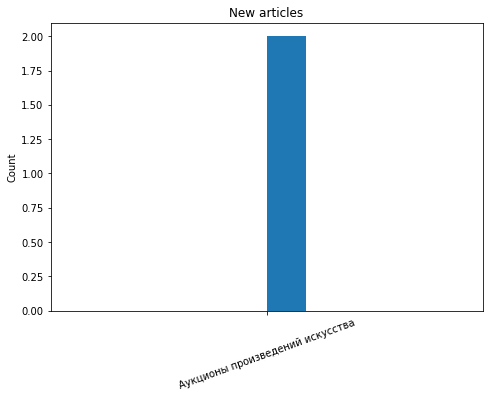


New articles titles:

Christie’s оценил триптих Фрэнсиса Бэкона в £35–55 млн
Sotheby’s продал черный бриллиант «Энигма» за криптовалюту

/theartnewspaper_long_text.csv

Articles counting



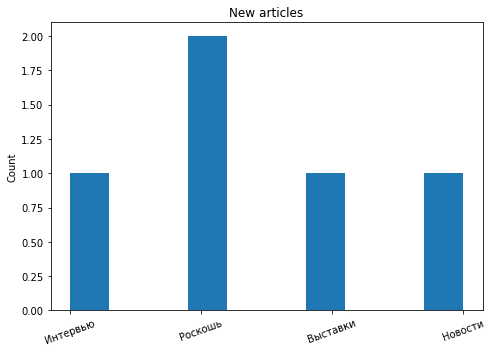


New articles titles:

Елена Шарнова: «Юбер Робер удивительно совпал с русским вкусом»
Романтика высокой кухни
День святого Tiffany
В Ruarts выставили чистые объекты нового городского художника
В Новой Третьяковке пройдет симпозиум New Elements


In [ ]:
for name, df in combo_df_dict.items():
  print('')
  print(name)
  print('')
  get_articles_graphic(df) # 16. Articles counting

Checking responses status & Parsing date



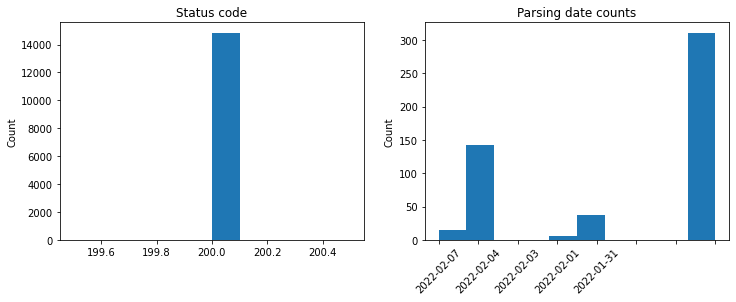

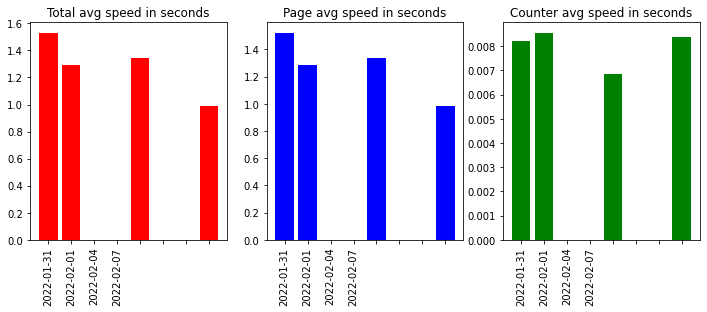

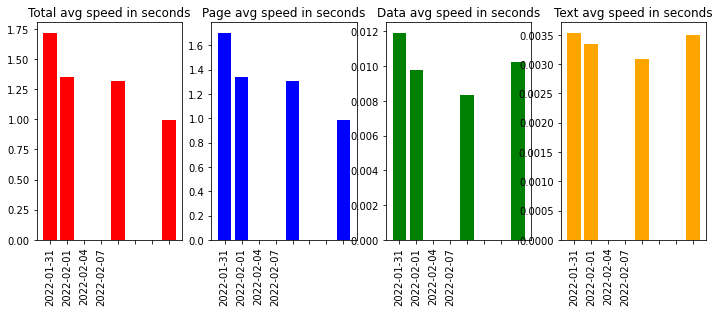

In [ ]:
# unify
get_stat_graphics() # 15. Stat graphics

## df info

In [56]:
# new info
for key, value in df_dict.items():
  for v in value:
    print(v)
    print('')
    try:
      df = open_file_csv(v, 'live') # 2. Open file.csv
      df.info()
    except:
      continue
    finally:
      print('')

-


/theartnewspaper_data_new.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               212 non-null    object 
 1   link               212 non-null    object 
 2   title              212 non-null    object 
 3   short_text         212 non-null    object 
 4   page_url           212 non-null    object 
 5   page_title         212 non-null    object 
 6   long_text_url      212 non-null    object 
 7   parsing_date       212 non-null    object 
 8   parsing_time       212 non-null    object 
 9   parsing_sec_speed  212 non-null    float64
dtypes: float64(1), object(9)
memory usage: 16.7+ KB

/theartnewspaper_long_text.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  --

In [ ]:
# previous info
for name, df in opened_df_dict.items():
  print(name)
  print('')
  df.info()
  print('')

artinvest_news_articles_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12984 entries, 0 to 12983
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               12984 non-null  object 
 1   link               12984 non-null  object 
 2   title              12984 non-null  object 
 3   short_text         12984 non-null  object 
 4   page_url           12984 non-null  object 
 5   page_title         12984 non-null  object 
 6   parsing_date       12984 non-null  object 
 7   parsing_time       12984 non-null  object 
 8   parsing_sec_speed  12984 non-null  float64
 9   long_text_url      12984 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1014.5+ KB

artinvest_long_text_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12984 entries, 0 to 12983
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----

In [ ]:
index = 0
for name, df in opened_df_dict.items():
  print(name, index)
  print('')
  index += 1

artinvest_news_articles_data 0

artinvest_long_text_df 1

artinvest_pages_counter_stat 2

theartnewspaper_data 3

theartnewspaper_long_text_df 4

page_statistic 5



In [ ]:
opened_df_dict['artinvest_news_articles_data'].head()

,date,link,title,short_text,page_url,page_title,parsing_date,parsing_time,parsing_sec_speed,long_text_url
0,08.12.2021,20211208_Aphrodite_sale.html,"Римская скульптура Афродиты продана за $24,6 млн",Это новый рекорд цены на античную мраморную ск...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211208...
1,07.12.2021,20211207_Pak_The_Merge_Sale.html,"NFT-проект цифрового художника Pak принес $91,...",Результат распродажи токенов из проекта The Me...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211207...
2,06.12.2021,20211206_GES2_opening.html,В Москве открыли новое культурное пространство...,Дом культуры «ГЭС-2» открылся в эту субботу в ...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211206...
3,25.11.2021,20211125_Elisium_Antique_salon.html,Галерея «Элизиум» приглашает посетить свой сте...,В Гостином дворе до 28 ноября открыт 47-й Росс...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211125...
4,24.11.2021,20211124_Art_Wars_NFT.html,Вокруг токенов по мотивам «Звездных войн» разы...,Группа современных художников намерена судитьс...,https://artinvestment.ru/news/artnews/,Новости искусства,2022-01-14,19:57:45.914374,0.010499,https://artinvestment.ru/news/artnews/20211124...


## artinvestment.ru

In [ ]:
artinvest_long_text_df['long_text'][0]

"['Вчера, 7 декабря 2021,  аукционный дом Sotheby’s провел в своем лондонском офисе  торги одного лота — римской мраморной скульптуры богини Афродиты, известной как  Афродита Гамильтона (по имени одного из владельцев). Лот был выставлен с  оценкой £2–3 млн, но в ходе 20-минутной аукционной борьбы между пятью  претендентами скульптура превысила эстимейт как минимум в девять раз. Новому  владельцу — некому азиатскому клиенту Sotheby’s,  чьи ставки называла менеджер по работе с клиентами Николь Чинг — Афродита  Гамильтона досталась за £18,6 млн ($24,6 млн) с учетом комиссии аукционного  дома. Это новый аукционный рекорд для античной мраморной скульптуры.', 'Афродита Гамильтона  была продана дороже, чем античный мраморный бюст Антиноя II в. н. э., за  который в 2010 году заплатили $23,8 млн. Впрочем результатам Афродиты и Антиноя  не удастся потягаться с абсолютным рекордом для древней скульптуры вообще: с  2007 года он безраздельно принадлежит миниатюрной 8-сантиметровой вавилонской  стат

In [ ]:
artinvest_long_text_df['sourses'][0]

"['https://www.artnews.com/art-news/market/hamilton-aphrodite-auction-record-1234612590/', 'https://observer.com/2021/11/a-scotsmans-beloved-hamilton-aphrodite-is-going-up-for-auction-at-sothebys/']"

In [ ]:
print(artinvest_news_articles_data['page_url'][0])
print(artinvest_news_articles_data['long_text_url'][0])

https://artinvestment.ru/news/artnews/
https://artinvestment.ru/news/artnews/20211208_Aphrodite_sale.html


In [ ]:
data = open_news_articles_data(artinvest_d)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               12980 non-null  object 
 1   link               12980 non-null  object 
 2   title              12980 non-null  object 
 3   short_text         12980 non-null  object 
 4   page_url           12980 non-null  object 
 5   page_title         12980 non-null  object 
 6   parsing_date       12980 non-null  object 
 7   parsing_time       12980 non-null  object 
 8   parsing_sec_speed  12980 non-null  float64
 9   long_text_url      12980 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1014.2+ KB


In [ ]:
data['date_type'] = data['date'].apply(lambda x: type(x))
data['parsing_date_type'] = data['parsing_date'].apply(lambda x: type(x))
data[['date', 'date_type', 'parsing_date', 'parsing_date_type']].head()

,date,date_type,parsing_date,parsing_date_type
0,08.12.2021,<class 'str'>,2022-01-14,<class 'str'>
1,07.12.2021,<class 'str'>,2022-01-14,<class 'str'>
2,06.12.2021,<class 'str'>,2022-01-14,<class 'str'>
3,25.11.2021,<class 'str'>,2022-01-14,<class 'str'>
4,24.11.2021,<class 'str'>,2022-01-14,<class 'str'>


## theartnewspaper.ru

In [ ]:
theartnewspaper_data.groupby(['page_url']).size()

page_url
https://www.theartnewspaper.ru/sections/conservation         22
https://www.theartnewspaper.ru/sections/interviu             22
https://www.theartnewspaper.ru/sections/luxury               31
https://www.theartnewspaper.ru/sections/markets              22
https://www.theartnewspaper.ru/sections/mercedes-benz         7
https://www.theartnewspaper.ru/sections/muzei-budushchego     6
https://www.theartnewspaper.ru/sections/news                 25
https://www.theartnewspaper.ru/sections/shows                26
dtype: int64

In [ ]:
theartnewspaper_data.groupby(['page_title']).size()

page_title
Cartier                 1
Арт-рынок              21
Выставки               23
Екатеринбург Россия     1
Интервью               18
Крупным планом          1
Москва Россия           1
Музей будущего          6
Назначения              1
Новости                27
Париж Франция           1
Реставрация            21
Роскошь                37
Спецпроект              1
Фестивали               1
dtype: int64

In [ ]:
#theartnewspaper_w_text = theartnewspaper_w_text.drop(['long_text_len'], axis=1)

In [ ]:
theartnewspaper_w_text.head(20)

,date,link,title,short_text,page_url,page_title,parsing_date,parsing_time,parsing_sec_speed,long_text_url,long_text,sourses,parsing_sec_speed_2,autors,add_info,long_text_len
0,2021-11-15,/posts/20211114-qlgw/,Sotheby’s сделал ставку на трагедию Фриды Кало,Автопортрет с изображением ее мужа Диего Ривер...,https://www.theartnewspaper.ru/sections/markets,Арт-рынок,2022-02-07,11:56:44.414338,0.024687,https://www.theartnewspaper.ru/posts/20211114-...,['\nSotheby’s сделал ставку на трагедию Фриды ...,[],0.008358,"Анна Савицкая, Гарет Харрис",[],5305
1,2021-11-12,/posts/20211112-yddp/,Ярмарка Paris Photo: больше молодых художников...,После года пропуска парижская ярмарка фотограф...,https://www.theartnewspaper.ru/sections/markets,Арт-рынок,2022-02-07,11:56:44.414338,0.024687,https://www.theartnewspaper.ru/posts/20211112-...,['\nЯрмарка Paris Photo: больше молодых художн...,[],0.008924,"Наташа Волински, The Art Newspaper Russia","['/sections/parizh-frantsiia/', 'Париж Франция']",4308
2,2021-09-22,/posts/20210922-puna/,В Русском музее завершилась реставрация трех г...,В числе самых древних документов музейного отд...,https://www.theartnewspaper.ru/sections/conser...,Реставрация,2022-02-07,11:56:50.613187,0.024965,https://www.theartnewspaper.ru/posts/20210922-...,['\nВ Русском музее завершилась реставрация тр...,[],0.007935,Наталья Шкуренок,[],4509
3,2021-12-27,/posts/20211227-kuzc/,"Наталья Кочнева: «Ситуация, когда бизнес помог...",Начальник управления корпоративной социальной ...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211227-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.011300,Людмила Лунина,[],13139
4,2021-12-22,/posts/20211221-cnbq/,"АЕS + F: «В музеях должны быть интрига, комфор...","О том, как жизнь отдыхающих может вдохновить н...",https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211221-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.009344,Людмила Лунина,[],12330
5,2021-12-02,/posts/20211201-gguv/,Дмитрий Озерков: «Музей — извечный компромисс ...,Глава отдела современного искусства «Эрмитаж 2...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211201-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.008470,Наталья Шкуренок,[],12045
6,2021-11-09,/posts/20211108-piuk/,"Жан-Юбер Мартен: «Пандемия подчеркнула, что му...","Знаменитый куратор рассказал нам о том, чем жи...",https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211108-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.008470,Светлана Янкина,[],8996
7,2021-10-28,/posts/20211028-ymvz/,Кристина Краснянская: «Никакая цифровая истори...,Исполнительный директор Еврейского музея и цен...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20211028-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.008313,Татьяна Маркина,[],16944
8,2021-09-22,/posts/20210916-sfsh/,Зельфира Трегулова: «Сейчас в музее нам нужны ...,Директор Третьяковской галереи Зельфира Трегул...,https://www.theartnewspaper.ru/sections/muzei-...,Музей будущего,2022-02-07,11:56:56.482540,0.018055,https://www.theartnewspaper.ru/posts/20210916-...,['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,[],0.011342,Милена Орлова,[],18237
9,2022-01-26,/posts/20220126-qtmi/,Сергей Лимонов: «Мы часто начинали с весьма ст...,Представитель нового поколения коллекционеров ...,https://www.theartnewspaper.ru/sections/interviu,Арт-рынок,2022-02-07,11:57:02.735455,0.023936,https://www.theartnewspaper.ru/posts/20220126-...,['\nСергей Лимонов: «Мы часто начинали с весьм...,[],0.009623,Тобин Обер,"['/sections/interviu/', 'Интервью']",5160

In [ ]:
for t in theartnewspaper_w_text['long_text'][3:8]:
  print(t)

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nНачальник управления корпоративной социальной ответственности, старший вице-президент банка ВТБ Наталья Кочнева рассказала нам о современных вариантах взаимодействия бизнеса и культуры\n\nЛюдмила Лунина\n\n27.12.2021\n', '\n\nМир изменился. Пандемия разъединила нас и в то же время соединила, показала нам важность общности не только отдельных людей, но и разных сфер: культуры и бизнеса, искусства и финансов. За это время стало очевидно, что всех нас волнуют одни и те же вопросы, поэтому вместе с банком ВТБ мы хотим зафиксировать этот момент в истории и попытаться понять, что нас ждет впереди. В рамках рубрики «Музей будущего» мы публиковали разговоры с крупнейшими игроками на поле искусства о том, что уже переменилось и чего нам ждать дальше: какими будут музеи, во что превратятся выставочные и образовательные проекты, упрочится ли роль мецената и в целом насколько перспективно будет партнерство культуры и бизнеса. Нашими героями стали дир